# Image Gradients
In this notebook we'll introduce the TinyImageNet dataset and a deep CNN that has been pretrained on this dataset. You will use this pretrained model to compute gradients with respect to images, and use these image gradients to produce class saliency maps and fooling images.

In [52]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introducing TinyImageNet

The TinyImageNet dataset is a subset of the ILSVRC-2012 classification dataset. It consists of 200 object classes, and for each object class it provides 500 training images, 50 validation images, and 50 test images. All images have been downsampled to 64x64 pixels. We have provided the labels for all training and validation images, but have withheld the labels for the test images.

We have further split the full TinyImageNet dataset into two equal pieces, each with 100 object classes. We refer to these datasets as TinyImageNet-100-A and TinyImageNet-100-B; for this exercise you will work with TinyImageNet-100-A.

To download the data, go into the `cs231n/datasets` directory and run the script `get_tiny_imagenet_a.sh`. Then run the following code to load the TinyImageNet-100-A dataset into memory.

NOTE: The full TinyImageNet-100-A dataset will take up about 250MB of disk space, and loading the full TinyImageNet-100-A dataset into memory will use about 2.8GB of memory.

In [53]:
print "start...."
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
print "end..."

start....
loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100
end...


# TinyImageNet-100-A classes
Since ImageNet is based on the WordNet ontology, each class in ImageNet (and TinyImageNet) actually has several different names. For example "pop bottle" and "soda bottle" are both valid names for the same class. Run the following to see a list of all classes in TinyImageNet-100-A:

In [5]:
print "start..."
for i, names in enumerate(data['class_names']):
  print i, ' '.join('"%s"' % name for name in names)
print "end..."

start...
0 "Egyptian cat"
1 "reel"
2 "volleyball"
3 "rocking chair" "rocker"
4 "lemon"
5 "bullfrog" "Rana catesbeiana"
6 "basketball"
7 "cliff" "drop" "drop-off"
8 "espresso"
9 "plunger" "plumber's helper"
10 "parking meter"
11 "German shepherd" "German shepherd dog" "German police dog" "alsatian"
12 "dining table" "board"
13 "monarch" "monarch butterfly" "milkweed butterfly" "Danaus plexippus"
14 "brown bear" "bruin" "Ursus arctos"
15 "school bus"
16 "pizza" "pizza pie"
17 "guinea pig" "Cavia cobaya"
18 "umbrella"
19 "organ" "pipe organ"
20 "oboe" "hautboy" "hautbois"
21 "maypole"
22 "goldfish" "Carassius auratus"
23 "potpie"
24 "hourglass"
25 "seashore" "coast" "seacoast" "sea-coast"
26 "computer keyboard" "keypad"
27 "Arabian camel" "dromedary" "Camelus dromedarius"
28 "ice cream" "icecream"
29 "nail"
30 "space heater"
31 "cardigan"
32 "baboon"
33 "snail"
34 "coral reef"
35 "albatross" "mollymawk"
36 "spider web" "spider's web"
37 "sea cucumber" "holothurian"
38 "backpack" "back pac

# Visualize Examples
Run the following to visualize some example images from random classses in TinyImageNet-100-A. It selects classes and images randomly, so you can run it several times to see different images.

start...


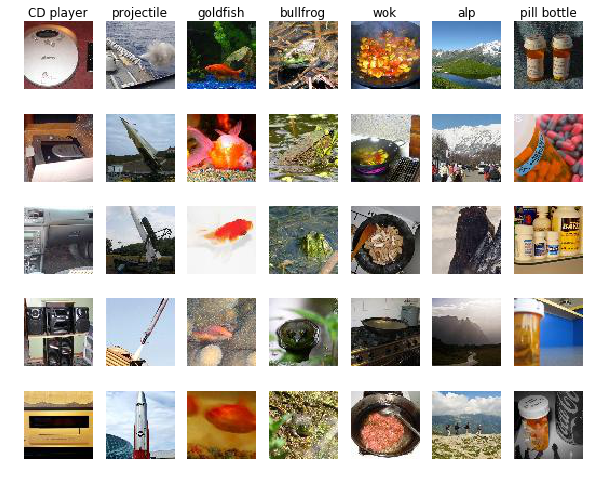

end...


In [6]:
# Visualize some examples of the training data
print "start..."
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(data['class_names']), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
  train_idxs, = np.nonzero(data['y_train'] == class_idx)
  train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
  for j, train_idx in enumerate(train_idxs):
    img = deprocess_image(data['X_train'][train_idx], data['mean_image'])
    plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
    if j == 0:
      plt.title(data['class_names'][class_idx][0])
    plt.imshow(img)
    plt.gca().axis('off')

plt.show()
print "end..."

# Pretrained model
We have trained a deep CNN for you on the TinyImageNet-100-A dataset that we will use for image visualization. The model has 9 convolutional layers (with spatial batch normalization) and 1 fully-connected hidden layer (with batch normalization).

To get the model, run the script `get_pretrained_model.sh` from the `cs231n/datasets` directory. After doing so, run the following to load the model from disk.

In [55]:
print "start.pretrained model..."
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')
#print "model:",model.params['gamma%d' % 1]
print "end.pretrained model..."

start.pretrained model...
end.pretrained model...


## Pretrained model performance
Run the following to test the performance of the pretrained model on some random training and validation set images. You should see training accuracy around 90% and validation accuracy around 60%; this indicates a bit of overfitting, but it should work for our visualization experiments.

In [56]:
print "start..."
batch_size = 100

# Test the model on training data
mask = np.random.randint(data['X_train'].shape[0], size=batch_size)
X, y = data['X_train'][mask], data['y_train'][mask]
print "X.shape:",X.shape
y_pred = model.loss(X).argmax(axis=1)
print 'Training accuracy: ', (y_pred == y).mean()

# Test the model on validation data
mask = np.random.randint(data['X_val'].shape[0], size=batch_size)
X, y = data['X_val'][mask], data['y_val'][mask]
y_pred = model.loss(X).argmax(axis=1)
print 'Validation accuracy: ', (y_pred == y).mean()
print "end..."

start...
X.shape: (100L, 3L, 64L, 64L)
Training accuracy:  0.92
Validation accuracy:  0.59
end...


# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [1].

As mentioned in Section 2 of the paper, you should compute the gradient of the image with respect to the unnormalized class score, not with respect to the normalized class probability.

You will need to use the `forward` and `backward` methods of the `PretrainedCNN` class to compute gradients with respect to the image. Open the file `cs231n/classifiers/pretrained_cnn.py` and read the documentation for these methods to make sure you know how they work. For example usage, you can see the `loss` method. Make sure to run the model in `test` mode when computing saliency maps.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [22]:
def compute_saliency_mapsX(X, y, model):#fine.
  """
  Compute a class saliency map using the model for images X and labels y.
  
  Input:
  - X: Input images, of shape (N, 3, H, W) ----->The input to the starting layer. an array of shape (N, C, 64, 64).
  - y: Labels for X, of shape (N,)
  - model: A PretrainedCNN that will be used to compute the saliency map.
  
  Returns:
  - saliency: An array of shape (N, H, W) giving the saliency maps for the input
    images.
  """
  saliency = None
  ##############################################################################
  # TODO: Implement this function. You should use the forward and backward     #
  # methods of the PretrainedCNN class, and compute gradients with respect to  #
  # the unnormalized class score of the ground-truth classes in y.             #
  ##############################################################################
  #1.forward pass to get scores.
  #scores, cache = model.forward(X, mode='test')
  #loss,dscores=softmax_loss(scores,y)  
  #2.backward pass to get gradients
  #dX,grads=model.backward(dscores,cache) #dx.shape (N, 3, H, W)--------------->saliency.shape(N, H, W)
  #3.
  #saliency=np.max(dX,axis=1)
    
  scores, cache = model.forward(X, mode='test')
  dscores = np.ones(scores.shape)
  w, _ = model.backward(dscores, cache)   #w is the gradient of the score w.r.t. the input images
  saliency = np.max(np.abs(w),axis = 1)
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return saliency

In [23]:
def softmax_lossX(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  #probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx

In [24]:
def compute_saliency_maps(X, y, model):
    print "test...."
    #1.feed in zeros images.
    saliency=np.zeros((X.shape))
    for i in xrange(1):
        #2.set the gradient of the scores vector to be all zeros except correct one.
        scores_, cache = model.forward(X, mode='test') #(5L, 100L)
        loss,dscores=softmax_lossX(scores_,y) 
        #N,class_num=scores_.shape
        #dscores=np.zeros(scores_.shape)
        #dscores[xrange(N),y]=1
        #print "scores:",scores
        #3.backprop the image
        dX, _ = model.backward(dscores, cache)
        #4.do a small "image update"
        #saliency-=dX*400
        saliency = np.max(np.abs(dX),axis = 1)
        #5.forward the image though the nextwork
        #scores_, cache = model.forward(X, mode='train')
        #6.go back to step2.
        #print "scores.shape:",scores.shape,"y.shape:",y.shape #scores.(5L, 100L) y.shape: (5L,)
    return saliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on the validation set of TinyImageNet-100-A.

start...
test....


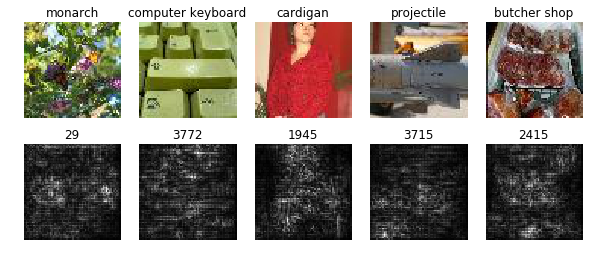

test....


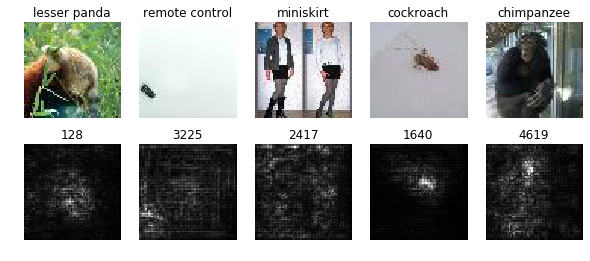

end...


In [25]:
from cs231n.layers import *
print "start..."
def show_saliency_maps(mask):
  mask = np.asarray(mask)
  X = data['X_val'][mask]
  y = data['y_val'][mask]

  saliency = compute_saliency_maps(X, y, model)

  for i in xrange(mask.size):
    plt.subplot(2, mask.size, i + 1)
    plt.imshow(deprocess_image(X[i], data['mean_image']))
    plt.axis('off')
    plt.title(data['class_names'][y[i]][0])
    plt.subplot(2, mask.size, mask.size + i + 1)
    plt.title(mask[i])
    plt.imshow(saliency[i])
    plt.axis('off')
  plt.gcf().set_size_inches(10, 4)
  plt.show()

# Show some random images
mask = np.random.randint(data['X_val'].shape[0], size=5)
show_saliency_maps(mask)
  
# These are some cherry-picked images that should give good results
show_saliency_maps([128, 3225, 2417, 1640, 4619])
print "end..."

# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [2]. Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[2] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [38]:
def make_fooling_image(X, target_y, model):
  """
  Generate a fooling image that is close to X, but that the model classifies
  as target_y.
  
  Inputs:
  - X: Input image, of shape (1, 3, 64, 64)
  - target_y: An integer in the range [0, 100)
  - model: A PretrainedCNN
  
  Returns:
  - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
  """
  X_fooling = X.copy()
  ##############################################################################
  # TODO: Generate a fooling image X_fooling that the model will classify as   #
  # the class target_y. Use gradient ascent on the target class score, using   #
  # the model.forward method to compute scores and the model.backward method   #
  # to compute image gradients.                                                #
  #                                                                            #
  # HINT: For most examples, you should be able to generate a fooling image    #
  # in fewer than 100 iterations of gradient ascent.                           #
  ##############################################################################
  #Method1: based on dx to change X_fooling,that is too reduce lose to target class.
  scores, cache = model.forward(X_fooling, mode='test')
  loss, dscores = softmax_loss(scores, target_y)
  print "loss.init:",loss
  learning_rate_decay=1 #0.95
  for i in xrange(1000):
        w, _ = model.backward(dscores, cache)   #w is the gradient of the score w.r.t. the input images
        X_fooling -= w*400.0 #*learning_rate_decay
        scores, cache = model.forward(X_fooling, mode='test')
        loss, dscores = softmax_lossX(scores, target_y)  
        current_predict = scores[0].argmax()
        if i%30==0:
            print "target_y:",target_y,"current_predict:",current_predict
            print i,"loss:",loss
        if  current_predict==target_y: #loss<0.5: 
            break;
  print "w.shape:",w.shape,"X_fooling.shape:",X_fooling.shape,"loss:",loss
   
  #method2:  compute difference
  #iter=0
  #current_predict=90
  #while iter<100 and current_predict!= target_y:
  #      scores, cache = model.forward(X_fooling, mode='test') 
  #      current_predict = scores[0].argmax()  
  #      if current_predict!= target_y:
  #          dscores = np.zeros(scores.shape) #dscores as import for backward function--->dout: Gradient with respect to the ending layer
  #          dscores[:,target_y] = max(scores[:,current_predict] - scores[:,target_y],100) #1.get score difference，from current to target
  #          dscores[:,current_predict] = min(-scores[:,current_predict] + scores[:,target_y],-100)  
  #          w, _ = model.backward(dscores, cache)
  #          X_fooling +=w
  #          iter=iter+1
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return X_fooling

Run the following to choose a random validation set image that is correctly classified by the network, and then make a fooling image.

start...
loss.init: 15.5915584564
target_y: 67 current_predict: 69
0 loss: 14.7853746414
target_y: 67 current_predict: 69
30 loss: 1.53188824654
target_y: 67 current_predict: 1
60 loss: 0.074861869216
w.shape: (1L, 3L, 64L, 64L) X_fooling.shape: (1L, 3L, 64L, 64L) loss: -0.0
well done!


D:\program files\Anaconda222\lib\site-packages\ipykernel\__main__.py:25: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


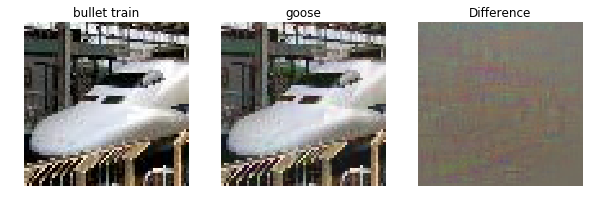

end...


In [39]:
print "start..."
# Find a correctly classified validation image
while True:
  i = np.random.randint(data['X_val'].shape[0])
  X = data['X_val'][i:i+1]
  y = data['y_val'][i:i+1]
  y_pred = model.loss(X)[0].argmax()
  if y_pred == y: break

target_y = 67
X_fooling = make_fooling_image(X, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = model.loss(X_fooling)
#assert scores[0].argmax() == target_y, 'The network is not fooled!'
if scores[0].argmax() != target_y:
    print 'The network is not fooled!'
else:
    print "well done!"

# Show original image, fooling image, and difference
plt.subplot(1, 3, 1)
plt.imshow(deprocess_image(X, data['mean_image']))
plt.axis('off')
plt.title(data['class_names'][y][0])
plt.subplot(1, 3, 2)
plt.imshow(deprocess_image(X_fooling, data['mean_image'], renorm=True))
plt.title(data['class_names'][target_y][0])
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(deprocess_image(X - X_fooling, data['mean_image']))
plt.axis('off')
plt.show()
print "end..."

# Transfer Learning with pretrained model
We have trained a deep CNN for you on the TinyImageNet-100-A dataset that we will use for image visualization. The model has 9 convolutional layers (with spatial batch normalization) and 1 fully-connected hidden layer (with batch normalization).

In [3]:
#Additional part in this notebook. this is using transfer learning with pretrained model in CNNs.
import numpy as np
#1.load pretrained model.
    #self.conv_params.append({'stride': 2, 'pad': 2}) #0
    #self.conv_params.append({'stride': 1, 'pad': 1}) #1
    #self.conv_params.append({'stride': 2, 'pad': 1}) #2
    #self.conv_params.append({'stride': 1, 'pad': 1}) #3
    #self.conv_params.append({'stride': 2, 'pad': 1}) #4
    #self.conv_params.append({'stride': 1, 'pad': 1}) #5
    #self.conv_params.append({'stride': 2, 'pad': 1}) #6
    #self.conv_params.append({'stride': 1, 'pad': 1}) #7
    #self.conv_params.append({'stride': 2, 'pad': 1}) #8
from cs231n.classifiers.pretrained_cnn import PretrainedCNN
#1.load or train on a (big) model.
print "start.pretrained model..."
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5') #,input_size=64, dtype=np.float32
#print "model:",model.params['gamma%d' % 1]
print "end.pretrained model..."
#that's suppose we will have a classification problem, but we only have small dataset. 
#we will keep all layers just as same, except last FC layer.

start.pretrained model...
start: 0 end+1: 11
i: 0 a conv layer. end: 10
i: 1 a conv layer. end: 10
i: 2 a conv layer. end: 10
i: 3 a conv layer. end: 10
i: 4 a conv layer. end: 10
i: 5 a conv layer. end: 10
i: 6 a conv layer. end: 10
i: 7 a conv layer. end: 10
i: 8 a conv layer. end: 10
i: 9 a FC layer.end: 10
i: 10 x.last FC.end: 10
end.pretrained model...


In [9]:
#2.load our own dataset.
import numpy as np
from six.moves import cPickle as pickle
#from six.moves import range
pickle_file = 'notMNIST.pickle'

sizez=100
with open(pickle_file, 'rb') as f:
  print "start..."
  save = pickle.load(f)
  train_dataset = save['train_dataset'][0:sizez]
  train_labels = save['train_labels'][0:sizez]
  valid_dataset = save['valid_dataset'][0:sizez]
  valid_labels = save['valid_labels'][0:sizez]
  test_dataset = save['test_dataset'][0:sizez]
  test_labels = save['test_labels'][0:sizez]
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('train_labels', train_labels.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

start...
('Training set', (100L, 28L, 28L), (100L,))
('train_labels', (100L,), (100L,))
('Validation set', (100L, 28L, 28L), (100L,))
('Test set', (100L, 28L, 28L), (100L,))


In [11]:
# 3.transfer dataset to target dataset, so it can proceessed by the model.
print "start..."
N,H,W=train_dataset.shape
C=3
train_dataset_transfered=np.zeros((H*W,C))
train_dataset_transfered_big=np.zeros((N,H*W,C))
for i in xrange(N):
    if i%5000==0:
        print "i:",i
    train_dataset_i=np.reshape(train_dataset[i,:,:],(H*W,1))
    sample_1by3=np.ones((1,3))
    train_dataset_transfered=train_dataset_i.dot(sample_1by3)
    train_dataset_transfered_big[i]=train_dataset_transfered
train_dataset_transfered_big=np.reshape(train_dataset_transfered_big,(N,H,W,C))
train_dataset_transfered_big=train_dataset_transfered_big.transpose(0,3,1,2) #transfer to (N,C,H,W)
print "train_dataset_transfered_big.shape:",train_dataset_transfered_big.shape
print "train_dataset_transfered_big[0,0,0,0]:",train_dataset_transfered_big[0,0,0,0]
print "end..."

start...
i: 0
train_dataset_transfered_big.shape: (100L, 3L, 28L, 28L)
train_dataset_transfered_big[0,0,0,0]: -0.5
end...


In [12]:
#Reshape from (3,28,28) to (3,64,64)
H_target=64
W_target=64
NN,CC,HH,WW=train_dataset_transfered_big.shape
train_dataset_transfered_big_target=np.zeros((NN,CC,H_target,W_target))
for i in xrange(N):
    #for each (3,28,28),do some matrix multiply
    for j in xrange(C):#for each (28,28)
        #reshape from (28,28) to (1,28*28)
        result=(np.reshape(train_dataset_transfered_big[i,j,:,:],(1,HH*WW))).dot(np.ones((HH*WW,H_target*W_target))) #should be (1,64*64)
        result2=np.reshape(result,(H_target,W_target))
        train_dataset_transfered_big_target[i,j,:,:]=result2
print "train_dataset_transfered_big_target.shape:",train_dataset_transfered_big_target.shape

train_dataset_transfered_big_target.shape: (100L, 3L, 64L, 64L)


In [13]:
#4.Extract features using pretrained model.
print "start...."
ii=9
feats, cache=model.forward(train_dataset_transfered_big_target,start=0, end=ii, mode='test')
#y_pred = model.loss(train_dataset_transfered_big).argmax(axis=1)
#print 'Validation accuracy: ', (y_pred == y).mean()
print "feats.shape:",feats.shape
print "end..."

start....
start: 0 end+1: 10
i: 0 a conv layer. end: 9
i: 1 a conv layer. end: 9
i: 2 a conv layer. end: 9
i: 3 a conv layer. end: 9
i: 4 a conv layer. end: 9
i: 5 a conv layer. end: 9
i: 6 a conv layer. end: 9
i: 7 a conv layer. end: 9
i: 8 a conv layer. end: 9
i: 9 a FC layer.end: 9
feats.shape: (100L, 512L)
end...


In [16]:
#5.Re-init last FC layer, train the last FC layer using our own dataset.
print "start..."
input_size=64#batch size=64
cur_size = input_size
i=ii+1
hidden_dim = 512# 512
num_classes=10
fan_in = cur_size * cur_size * model.num_filters[-1]
model.params['W%d' % (i + 2)] = np.sqrt(2.0 / fan_in) * np.random.randn(fan_in, hidden_dim) #
model.params['b%d' % (i + 2)] = np.zeros(hidden_dim)
model.params['gamma%d' % (i + 2)] = np.ones(hidden_dim)
model.params['beta%d' % (i + 2)] = np.zeros(hidden_dim)
model.bn_params.append({'mode': 'train'})
model.params['W%d' % (i + 3)] = np.sqrt(2.0 / hidden_dim) * np.random.randn(hidden_dim, num_classes)
model.params['b%d' % (i + 3)] = np.zeros(num_classes)
print "end..."

start...


MemoryError: 

In [15]:
#6.training the model.
print "start...."
from cs231n import layers
learning_rate=0.01
for i in xrange(100):
    print "i:",i
    feats, cache=model.forward(train_dataset_transfered_big_target, start=ii+1, mode='train') #X.shape should be: (100L, 3L, 64L, 64L)
    loss, dscores = softmax_loss(scores, train_labels)
    print "loss:",loss
    dX, grads = self.backward(dscores, cache)
    # Compute loss and gradient
    loss, grads = self.model.loss(features, captions)
    self.loss_history.append(loss)

    # Perform a parameter update
    for p, w in self.model.params.iteritems():
      dw = grads[p]
      model.params[p]=model.params[p]-learning_rate*dw
      #config = self.optim_configs[p]
      #next_w, next_config = self.update_rule(w, dw, config)
      #self.model.params[p] = next_w
      #self.optim_configs[p] = next_config
print "end..." 

start....
i: 0
start: 10 end+1: 11
i: 10 x.last FC.end: 10


ValueError: shapes (100,12288) and (512,100) not aligned: 12288 (dim 1) != 512 (dim 0)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
img.shape: (1600, 1200)


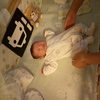

In [35]:
from PIL import Image
img = Image.open("children.jpg")
print type(img)
print "img.shape:",img.size
#im.show()
#im.rotate(300).show()
img.resize((100, 100), Image.ANTIALIAS)